**Important:** Each notebook can be executed independently and does not rely on running the others.

# 0. Installing and Importing the Necessary Libraries

#### General Installs and Imports that should be used in *Every Notebook*:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import re

#### For *Notebook 1. Data Exploration*:

In [ ]:
#!pip install langdetect
#!pip install wordcloud

In [ ]:
#from langdetect import detect
#from wordcloud import WordCloud

#### For *Notebook 2. Pre-Processing*:

In [ ]:
#!pip install langdetect
#!pip install ipython
#!pip install deep_translator
#!pip install nltk
#!pip install autocorrect
#!pip install spacy
#!pip install timeout-decorator
#!pip install contractions

In [ ]:
from langdetect import detect
from IPython import display
from deep_translator import GoogleTranslator
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from tqdm import tqdm
from autocorrect import Speller
import spacy
from sklearn.model_selection import train_test_split
from timeout_decorator import timeout, TimeoutError
import contractions

In [ ]:
#nltk.download("stopwords")
#nltk.download("wordnet")
#nltk.download('omw-1.4')
#nltk.download("en_core_web_sm")
#ltk.download('averaged_perceptron_tagger')

#### For Notebook 3. Feature Engineering:

In [ ]:
#!pip install -U sentence-transformers
#!pip install torch torchtext

In [ ]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer
from tqdm import tqdm
from collections import defaultdict
import torch
import torchtext.vocab as vocab
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#nltk.download('punkt')

# 1. Importing the Translated, Pre-Processed, Splitted (Training/Validation) Datasets

Importing the datasets that will require feature engineering so that they can be inputed in the models for training or prediction. These datasets are the following: train, validation, and test with the "host_about" and "description" textual fields, and the train, validation, and test with the "comments" textual fields.

In [ ]:
# Allowing access to our Google Drive where the original datasets are stored.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing our translated datasets.
df_train_reviews_processed = pd.read_excel("C:/Users/migue/Downloads/Text Mining Project/Text Mining Project/Splitted Training Dataset (Pre-Processed)/Pre-Processed/Training/train_reviews_split.xlsx")
df_train_processed = pd.read_excel("C:/Users/migue/Downloads/Text Mining Project/Text Mining Project/Splitted Training Dataset (Pre-Processed)/Pre-Processed/Training/train_split.xlsx")
df_val_reviews_processed = pd.read_excel("C:/Users/migue/Downloads/Text Mining Project/Text Mining Project/Splitted Training Dataset (Pre-Processed)/Pre-Processed/Validation/val_reviews_split.xlsx")
df_val_processed = pd.read_excel("C:/Users/migue/Downloads/Text Mining Project/Text Mining Project/Splitted Training Dataset (Pre-Processed)/Pre-Processed/Validation/val_split.xlsx")
df_test_reviews_processed = pd.read_excel("C:/Users/migue/Downloads/Text Mining Project/Text Mining Project/Test Dataset (Original, Translated, Pre-Processed)/Pre-Processed/test_reviews_pre_processed.xlsx")
df_test_processed = pd.read_excel("C:/Users/migue/Downloads/Text Mining Project/Text Mining Project/Test Dataset (Original, Translated, Pre-Processed)/Pre-Processed/test_pre_processed.xlsx")

In [ ]:
def fixing_nulls(df_host_about_description, df_comments):
    missing_keys = df_host_about_description[~df_host_about_description['index'].isin(df_comments['index'])]
    missing_indexes = pd.DataFrame({'index': missing_keys['index'], 'comments': ''})
    df_new_comments = df_comments.append(missing_indexes)
    df_new_comments = df_new_comments.reset_index(drop=True)

    return df_new_comments

In [ ]:
df_train_reviews_processed_fixed = fixing_nulls(df_train_processed, df_train_reviews_processed)
df_val_reviews_processed_fixed = fixing_nulls(df_val_processed, df_val_reviews_processed)
df_test_reviews_processed_fixed = fixing_nulls(df_test_processed, df_test_reviews_processed)

C:\Users\migue\AppData\Local\Temp\ipykernel_17568\1722808645.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new_comments = df_comments.append(missing_indexes)
C:\Users\migue\AppData\Local\Temp\ipykernel_17568\1722808645.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new_comments = df_comments.append(missing_indexes)
C:\Users\migue\AppData\Local\Temp\ipykernel_17568\1722808645.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new_comments = df_comments.append(missing_indexes)


In [ ]:
# Besides the splitted datasets, we also imported the train and validation
# datasets, as well as the original dataset. These datasets were important
# for the checking validation steps performed below (see step 2.4.4 and 2.4.5).

# Labels datasets
df_train_labels = pd.read_excel("C:/Users/migue/Downloads/train_labels_split.xlsx")
df_validation_labels = pd.read_excel("C:/Users/migue/Downloads/val_labels_split.xlsx")

# Originals datasets
df_original = pd.read_excel("C:/Users/migue/Downloads/Text Mining Project/Text Mining Project/Original Train Dataset (Original, Translated, Pre-Processed))/Original/train.xlsx")

## 1.2. Merging "description" and "host_about" columns

After taking an initial look at our splitted datasets, we made the decision to merge the "description" and "host_about" columns into a single textual column. This approach offered several benefits:

- A **simplified pipelined**, instead of applying separate feature engineering steps on each column, we only need to perform the feature engineering once on the merged column, making our code cleaner and more concise;
- **Avoiding duplication of the same words**, naturally, one from "description" and one from "host_about" column. By merging the columns, we avoided potential issues with duplication of the same words present in both the "description" and "host_about" columns;
- A **greater capture of interactions** between these two columns, since by merging them, we are able to capture potential interactions and relationships that otherwise would not be possible. These interactions may contain valuable information that can contribute to better modeling and prediction.

In [ ]:
df_train_splitted = df_train_processed.copy(deep=True)
df_validation_splitted = df_val_processed.copy(deep=True)
df_test_splitted = df_test_processed.copy(deep=True)

### 1.2.1 Train

In [ ]:
# Concatenate the 'description' and 'host_about' columns into a new column called 'merged_text'
df_train_splitted['description_host_about'] = df_train_splitted['description'].astype(str) + ' ' + df_train_splitted['host_about'].astype(str)

# Remove the original 'description' and 'host_about' columns if desired
df_train_splitted.drop(['description', 'host_about'], axis=1, inplace=True)

# Print the updated dataframe
df_train_splitted.head()

,index,description_host_about
0,2138,comfortable apartment private terrace quiet ar...
1,1967,space isbn hostel locate center isbn offer rel...
2,4308,spacious brand new guest house 4 independent r...
3,7126,proud offer exclusive apartment enjoy best pos...
4,4814,modern copy one bedroom apartment outdoor pati...


In [ ]:
# Testing our merge on the first row.
    # We validate that the merge was correctly executed.
train_example = df_train_splitted.at[0, 'description_host_about']
print(train_example)

comfortable apartment private terrace quiet area 15 minute drive center isbn airport equip air condition fast wifi free park front door metro station 15 minute walk bus stop 3 minute restaurant supermarket pharmacy local shop nearby license number 89047 al work deck officer portuguese merchant marine several year sale director sale train director project manager yellow page passionate travel love discover different culture also like shoot 360 degree panorama love meet people create bond like sea sunshine day good food good wine good living


### 1.2.2 Validation

In [ ]:
# Concatenate the 'description' and 'host_about' columns into a new column called 'merged_text'
df_validation_splitted['description_host_about'] = df_validation_splitted['description'].astype(str) + ' ' + df_validation_splitted['host_about'].astype(str)

# Remove the original 'description' and 'host_about' columns if desired
df_validation_splitted.drop(['description', 'host_about'], axis=1, inplace=True)

# Print the updated dataframe
df_validation_splitted.head()

,index,description_host_about
0,10849,stay traditional quiet neighborhood book pecul...
1,7261,apartment primeira 1 bedroom capacity 4 people...
2,6142,proud offer spacious elegant apartment quiet r...
3,4324,locate sao paulo area ideal home traveler wish...
4,9372,flat locate axis coxless include walk distance...


In [ ]:
# Testing our merge on the first row.
    # We validate that the merge was correctly executed.
validation_example = df_validation_splitted.at[0, 'description_host_about']
print(validation_example)

stay traditional quiet neighborhood book peculiar apartment full artistic hand paint detail tastefully decorate colorful pattern traditional accent enjoy live day maybe longer charm patio da palmeiras one old rare condominium isbn recently renovate space say detail matter decoration furniture placement small functional studio accommodate 2 people totally design comfort guests whether stay day month long day sightsee activity sure want rest comfortable double bed fresh fragrant bed great bathroom laundry room stand shower tower disposal kitchen extremely functional equip necessary utensil ap hopeful portuguese short term management service team offer exclusive service every step journey book flat ensure great stay please get contact question regard reservation happy help


### 1.2.3 Test

In [ ]:
# Concatenate the 'description' and 'host_about' columns into a new column called 'merged_text'
df_test_splitted['description_host_about'] = df_test_splitted['description'].astype(str) + ' ' + df_test_splitted['host_about'].astype(str)

# Remove the original 'description' and 'host_about' columns if desired
df_test_splitted.drop(['description', 'host_about'], axis=1, inplace=True)

# Print the updated dataframe
df_test_splitted.head()

,index,description_host_about
0,1,space apartment locate historic center isbn ap...
1,2,important response covid 19 property extend cl...
2,3,bright beautiful spacious four bedroom apartme...
3,4,charm apartment close bay cascade 1 bedroom do...
4,5,look holiday close beach casino tourist attrac...


In [ ]:
# Testing our merge on the first row.
    # We validate that the merge was correctly executed.
test_example = df_test_splitted.at[0, 'description_host_about']
print(test_example)

space apartment locate historic center isbn apartment space game history modernization finish since enter detail apartment wasteful interior finish apartment property value fully equip furnish copy bed linen tower kitchen textile apartment locate area rua de secolo jardin principle real jardin de pedro de alcantara 5 minute walk best area isbn child agenda da liberate large cam e alma castle taxa several church convent museum visit area urbanization isbn area begin sixteenth century construction house reign sebastian even survive great earthquake 1755 growth medium give lot excitement area like travel meet people like receive friend home love cinema love summer love family


## 1.3. Merging both Datasets (Train and Validation)

Before moving on to the TF-IDF itself, we decided to merge both our **training** and **validation** datasets to train our model.  <br>
This decision offers several advantages:

- **Vocabulary Consistency:** Since TF-IDF involves creating a vocabulary based on the entire dataset. By performing feature engineering separately on the training and validation datasets, we have the possibility of having different vocabularies for each dataset. So, merging the mentioned datasets ensures us that the vocabulary is consistent across the entire dataset, which leads to more meaningful and consistent feature representations.

- **N-grams Coverage:** N-grams are sequences of words or characters that provide context and capture important patterns in text data. When using N-grams in TF-IDF, it is essential to have a comprehensive coverage of N-grams in the dataset. By merging the datasets, we increase the likelihood of having a broader range of N-grams, as we incorporate more text data. This can lead to improved feature representation and model performance.

- **More efficiency and simplicity:** Merging the datasets allows you to perform the feature engineering process (fitting vectorizers, generating TF-IDF representations) in a single step, which is way more time efficient. This approach simplifies the implementation, and improves efficiency, making our code significantly more clean.

In [ ]:
# Merging the training with the validation datasets.
df_splitted_merged = pd.concat([df_train_splitted, df_validation_splitted], ignore_index=True)
df_splitted_merged

,index,description_host_about
0,2138,comfortable apartment private terrace quiet ar...
1,1967,space isbn hostel locate center isbn offer rel...
2,4308,spacious brand new guest house 4 independent r...
3,7126,proud offer exclusive apartment enjoy best pos...
4,4814,modern copy one bedroom apartment outdoor pati...
...,...,...
12491,6770,fantastic studio gate isbn 5 minute reboleira ...
12492,5216,live lovelisbon t1 duplex comfortable apartmen...
12493,10243,beautiful copy room relax exhaust day explore ...
12494,117,apartment locate city center metro 20 meter aw...


# 2. Feature Engineering

## 2.1. TF-IDF (Term Frequency-Inverse Document Frequency) with 1 N-Gram

**TF-IDF** is a very common numerical representation technique used in text mining and natural language processing. It measures the level of importance of each term within a certain aggregation of documents. Each term in a document is assigned a weight that reflects its significance value. The weight is calculated based on two factors: term frequency (TF) and inverse document frequency (IDF).

- **Term Frequency (TF):** Quantifies how frequently a term appears in a document (number of times a term appears in a document by the total number of terms in that document). Higher weights of a specific term, means more frequency within the respective document.

- **Inverse Document Frequency (IDF):** Measures the rarity or uniqueness of a term across the entire document collection (logarithm of the ratio of the total number of documents to the number of documents containing the term). Higher weight of a specific term, means that the term is less common across the document collection.

The score for a term in a document is obtained by multiplying its **TF** by its **IDF**. This results in a numerical representation that emphasizes terms that are both frequent within a document and relatively rare across the entire collection.

**Additional Insights on Shape and Values:** <br>
- Rows of the TF-IDF matrix indicate the number of documents;
- Columns of the TF-IDF matrix indicate the number of unique terms (columns) in the corpus;
- The TF-IDF matrices store the TF-IDF values for each document-term pair;
- Each non-zero entry represents the TF-IDF weight of a specific term in a specific document.

**Additional Insights on Sparsity:** <br>
- TF-IDF matrices are often sparse because most documents contain only a subset of the total vocabulary;
- This means that, as expected, most entries in the matrix are zero, and only non-zero entries represent the TF-IDF values.

<br>

In our approach, we tried a **TF-IDF with 2 N-Grams** approach, which is a variant of the TF-IDF technique that includes not only individual terms but also pairs of consecutive words (2-grams) as features. It calculates the importance of these **2 n-grams** within a document based on their frequency and rarity.

By considering 2-grams, the TF-IDF approach captures not only single words but also the pair word combinations, providing a more complex representation of the text. This can be very useful in capturing phrases, expressions, or contextual information that carry key meaning to the understanding of the text.

Nevertheless, this approach would be unfeasible for modelling and delivery purposes due to the size of the feature engineered datasets.

Therefore, we procedded with a **TF-IDF with 1 N-Grams** approach, which is a variant of the TF-IDF technique that includes all the individual terms (1-grams) as features. It calculates the importance of these **1 n-grams** within a document based on their frequency and rarity.

### 2.1.1 Creating an instance

In [ ]:
# Firstly, we created an instance of "TfidfVectorizer" for "description_host_about"
# column, called "vectorizer_wordgram".
# As specified in the parameters, we used 1 ngrams, whose benefits were
# previously described.
vectorizer_wordgram = TfidfVectorizer(ngram_range=(1, 1))

### 2.1.2 Training the merged dataset

In [ ]:
# Secondly, we fitted the respective vectorizer on the recently created
# text data column "description_host_about" using the "fit()" method.
_wordgram_fitted = vectorizer_wordgram.fit(df_splitted_merged['description_host_about'])

### 2.1.3 Transforming each splitted dataset (train, validation and test)



In [ ]:
# Thirdly, we transformed the vectorizers called "_wordgram_fitted" using the
# "transform()" method. We calculated the "TF-IDF weights" and generated the
# TF-IDF matrices for each column, storing the information on the variables:
# "train_matrix_wordgram", "val_matrix_wordgram" and "test_matrix_wordgram".

# Essentially, each of this matrix contains the different the weights assigned
# to each term per document. The weights represent the TF- IDF level of importance
# and each document represent an AIRBNB.

# Transform the training dataset.
train_matrix_wordgram = _wordgram_fitted.transform(df_train_splitted['description_host_about'])

# Transform the validation dataset.
val_matrix_wordgram = _wordgram_fitted.transform(df_validation_splitted['description_host_about'])

# Transform the test dataset.
test_matrix_wordgram = _wordgram_fitted.transform(df_test_splitted['description_host_about'])

### 2.1.4 Checking labels


Here, we performed our **first validation** over our TF-IDF transformations.
It consists in ensure whether that all the rows in both the training dataset (already transformed) and the original one datasets have **matching index** values and labels, thus confirming the consistency and accuracy of the transformations applied to the data.

In [ ]:
# In order to facilitate further analysis, we converted the transformed matrices
# into dataframes. This way, we have a clearer and easier to visualize our data,
# including the diferent indexes and feature names.

# Convert the transformed matrices to dataframes for further analysis.
df_train_splitted_tfidf_wordgram = pd.DataFrame(train_matrix_wordgram.toarray(), columns=vectorizer_wordgram.get_feature_names_out(), index=df_train_splitted["index"])
df_validation_splitted_tfidf_wordgram = pd.DataFrame(val_matrix_wordgram.toarray(), columns=vectorizer_wordgram.get_feature_names_out(), index=df_validation_splitted["index"])
df_test_splitted_tfidf_wordgram = pd.DataFrame(test_matrix_wordgram.toarray(), columns=vectorizer_wordgram.get_feature_names_out(), index=df_test_splitted["index"])

In [ ]:
# Creating two new dataframes with the transformed dataframes (both train and validation)
# with the respective label dataframes. We need these the "index" column in
# these two datasets in order to be able perform the "label"check.
df_train_labels_indexed = pd.concat([df_train_labels, df_train_splitted["index"]], axis=1)
df_validation_labels_indexed = pd.concat([df_validation_labels, df_validation_splitted["index"]], axis=1)

In [ ]:
# With the for loop below, we aim to compare the labels between the original dataset
# and the transformed dataset ('df_train_labels_indexed').
# It checks if the index values and labels of the corresponding rows are the same
# and keeps track of the index values that have matching rows.
matching_rows = []
for index_value in df_train_labels_indexed['index']:
    original_row = df_original[df_original['index'] == index_value]
    preprocessed_row = df_train_labels_indexed[df_train_labels_indexed['index'] == index_value]

    if original_row.empty or preprocessed_row.empty:
        continue

    if original_row['unlisted'].iloc[0] == preprocessed_row['unlisted'].iloc[0]:
        matching_rows.append(index_value)

# Print the matching rows.
    # As we can see, the number of matching rows has the same as the length of the
    # transformed training dataset.
    # So, we can conclude that the original datasets and the transformed one have matching
    # labels in 100% of the cases for the same index name.
    # We validate the procedure.
print(len(matching_rows))
print("Length of matching rows from train dataset is:", len(matching_rows))
print("Length of df_train_labels_indexed:", len(df_train_labels_indexed))

8747
Length of matching rows from train dataset is: 8747
Length of df_train_labels_indexed: 8747


In [ ]:
# Similarly to the rationale in the cell below, we followed the same reasoning
# to the validation dataset.
matching_rows = []
for index_value in df_validation_labels_indexed['index']:
    original_row = df_original[df_original['index'] == index_value]
    preprocessed_row = df_validation_labels_indexed[df_validation_labels_indexed['index'] == index_value]

    if original_row.empty or preprocessed_row.empty:
        continue

    if original_row['unlisted'].iloc[0] == preprocessed_row['unlisted'].iloc[0]:
        matching_rows.append(index_value)

# Print the matching rows.
    # As we can see, the number of matching rows has the same as the length of the
    # transformed validation dataset.
    # So, we can conclude that the original datasets and the transformed one have matching
    # labels in 100% of the cases for the same index name.
    # We validate the procedure.
print(len(matching_rows))
print("Length of matching rows from validation dataset is:", len(matching_rows))
print("Length of df_train_labels_indexed:", len(df_validation_labels_indexed))

3749
Length of matching rows from validation dataset is: 3749
Length of df_train_labels_indexed: 3749


### 2.1.5 Checking matching indexes

Our second validation step, aims to check whether the columns with non-zero weights of the last row (which corresponds to the last document), were aligned with the words presented in the corresponding AIRBNB in the original merged file (in both “description” and “host_about” columns”). To perform this validation, we selected the last row of the DataFrame, which is the number 8065. By examining this index, we confirmed that the single and double words, representing 2-grams, are indeed present in both the "description" and "host_about" columns of the original merged file.

For example, the "description" column starts with "family getaway", on the original merged file. There is both the word "family" and "family getaway" in the transformed dataframe.

In [ ]:
# The code below iterates through every value and corresponding column name
# in "df_train_splitted_tfidf_wordgram" dataFrame for the row 8065 (the last one).
# If a value in the row is greater than 0, it prints the column name and the corresponding value.

# Defining the row index
row_index = 8065

# Access the specific row and retrieve the values
row_values = df_train_splitted_tfidf_wordgram.iloc[row_index].values

# Get the column names from the DataFrame
column_names = df_train_splitted_tfidf_wordgram.columns

# Iterate over the values and corresponding column names
for value, column_name in zip(row_values, column_names):
    if value > 0:
        print(f"Column: {column_name}, Value: {value}")

Column: 1st, Value: 0.09400739777871057
Column: access, Value: 0.0406204419028947
Column: air, Value: 0.05522947333944164
Column: also, Value: 0.09278619609448058
Column: area, Value: 0.07958276980291491
Column: back, Value: 0.07632913765241581
Column: balcony, Value: 0.1187631244694276
Column: bathroom, Value: 0.11363903362800179
Column: bb, Value: 0.11088287265880033
Column: beautiful, Value: 0.04982133898945723
Column: bedroom, Value: 0.03573241609648083
Column: clean, Value: 0.0634299004431961
Column: cleaning, Value: 0.08300688141848417
Column: complete, Value: 0.1699755114190007
Column: condition, Value: 0.06910099160635917
Column: connect, Value: 0.09304152745906251
Column: corner, Value: 0.17419385496717651
Column: designer, Value: 0.0961965681788106
Column: din, Value: 0.12137412965665402
Column: direct, Value: 0.09942751028260889
Column: disney, Value: 0.18769038238432995
Column: door, Value: 0.0749054369147896
Column: dry, Value: 0.1059760432432072
Column: enjoy, Value: 0.04

In [ ]:
# Defining the row index
row_index = 8065

# Access the 'description_host_about' column from the merged DataFrame before
# applying TF-IDF.
text_column = df_splitted_merged['description_host_about']

# Get the specific text value for the given row index number 8065.
text_value = text_column.iloc[row_index]

# Print the text value
print(text_value)

family getaway pool gym corner clean stay space main floor present modern spacious living room glass door open exotic garden swim pool find lounge seating outdoor din area complete bb fully equip beautiful open space kitchen din room also level well powder room 1st floor present spacious modern master suite feature balcony complete bathroom 2 bedroom connect balcony share full bathroom garage feature gym corner direct access house playbook area well bathroom kid enjoy ground floor laundry room wash dry machine also find air condition wi fi multi lingual tv netflix disney thing note price include cleaning designer isbn get married move switzerland back portugal small kid still love travel try often hope help wonderful experience family home


### 2.1.6 Checking importance level

Before moving on to more complext feature engineering methods, we decided to plot the top 20 most important features across all documents in our dataset, in terms of TF-IDF scores. A high TF-IDF score means that a term is, at the same time, frequent within a specific document and relatively uncommon across the entire corpus.
By analyzign the training dataset, the 5 main features we obtain were:
- **apartment**;
- **isbn**;
- **room**;
- **guest**;
- **bed**;

At some extend, it make sense, taking into consideration the context of our analysis (an AIRBNB), but the results are all lower than **0.03** (except **apartment**), which is not particularly significant.

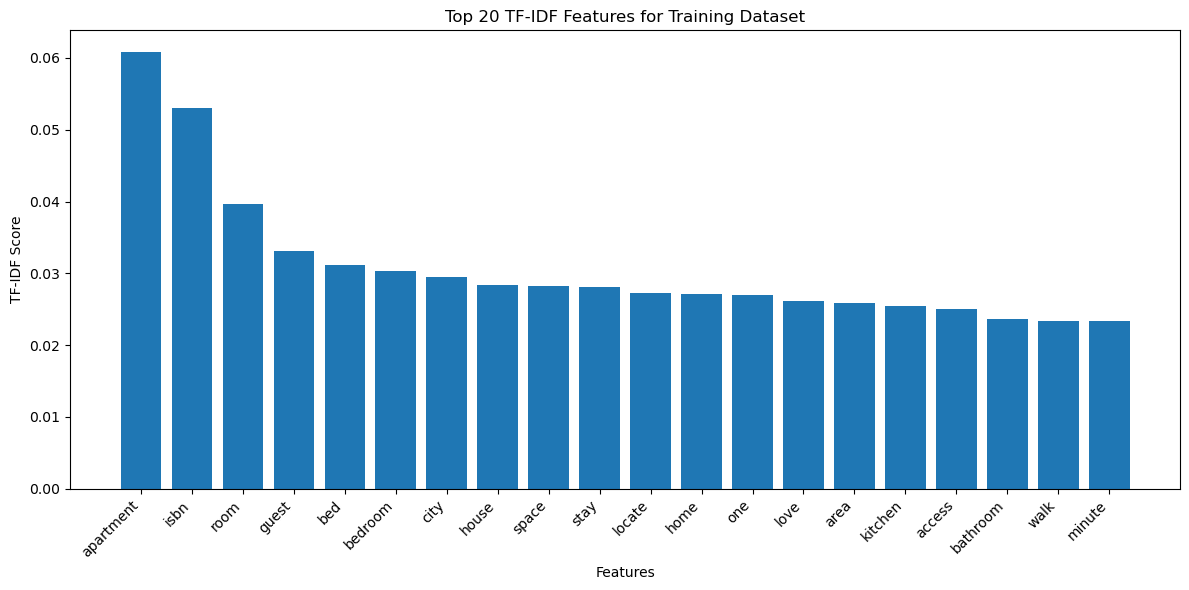

In [ ]:
# Calculate the mean TF-IDF score for each feature in the training dataset
feature_scores = df_train_splitted_tfidf_wordgram.mean().tolist()

# Sort the features based on their scores in descending order
sorted_scores, sorted_features = zip(*sorted(zip(feature_scores, df_train_splitted_tfidf_wordgram.columns), reverse=True))

# Select the top 20 features to visualize
top_n = 20
top_scores = sorted_scores[:top_n]
top_features = sorted_features[:top_n]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(range(top_n), top_scores, align='center')
plt.xticks(range(top_n), top_features, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('TF-IDF Score')
plt.title('Top {} TF-IDF Features for Training Dataset'.format(top_n))
plt.tight_layout()
plt.show()

In [ ]:
# Saving our three files into distinct csv files.
#from google.colab import files
#df_train_splitted_tfidf_wordgram.to_csv('train_host_about_tfidf.csv', index=False)
#files.download('train_host_about_tfidf.csv')
# df_validation_splitted_tfidf_wordgram.to_csv('validation_host_about_tfidf.csv', index=False)
# files.download('validation_host_about_tfidf.csv')
# df_test_splitted_tfidf_wordgram.to_csv('test_host_about_tfidf.csv', index=False)
# files.download('test_host_about_tfidf.csv')

## 2.2. GloVe Embedding

GloVe (Global Vectors for Word Representation) is a popular word embedding technique that represents words as dense vectors in a high-dimensional space. GloVe is designed to capture the semantica relationships between words based on their co-occurence statistics in a given corpus.

It starts by creating a co-occurence matrix to measure how often words appear together in a corpus. From this matrix, a probability distribtuion is derived. Word vectors are initialized randomly and then trained using an iterative process to minimize a loss function that captures the mismatch between the dot product of word vectors and the logarithm of co-occurence probabilities. The trained word vectors form a dense representation of words in a vector space, capturing semantica relationships. GloVe's advantage liers in its ability to incorporate both local and global co-occurerence statistics. These word embeddings are useful in various natural language processing tasks.

Our approach to embedding involves individually embedding each word and then summing the embeddings of words within the same sentence. Additionally, we sum the embeddings of sentences that correspond to the same index, specifically for "comments". We adopted this strategy to optimize memory usage since a separate embedding for each word would require a significant amount of space. However, it's important to note that this approach may lead to decreased efficiency in the model.



In [ ]:
# Initiating the GloVe model with the vocab functiom from the torchtext library.
glove = vocab.GloVe(name="6B", dim=100)

.vector_cache/glove.6B.zip: 862MB [02:43, 5.28MB/s]                           
100%|█████████▉| 399999/400000 [00:26<00:00, 15367.91it/s]


In [ ]:
# Function that given a dataframe and a column will first sum the embeddings of the words
# of a given sentence so that we have a unique embedding per sentence. Then it will also
# sum the embeddings of the sentences with the same index so that we have a unique
# embedding per index for each one of the columns. The output will be a single embedding
# for each index on the column we specified.
def transformer_embedding(dataframe, column):

  # Transforming in a list the column we want to apply the feature engineering.
  to_embed = list(dataframe[column])

  # Initiating a storage list that will save the single embedding of each sentence.
  storage = []

  # Iterating with each one of the sentences in the column we selected.
  for string in to_embed:

    # Tokenizing the sentence.
    tokens = word_tokenize(str(string))

    # Initiating the sentence embedding with the embedding of an empty string as a placeholder,
    # the embedding of an empty string is just a list of 0's.
    sentence_embedding = glove[""]

    # Iterating with each one of the tokens.
    for token in tokens:

      # If the token comes from a null representation we just add the embedding of an
      # empty string.
      if token == "nan":
        sentence_embedding += glove[""]
      else:
        # For each token of a sentence we keep summing them to the previously
        # created placeholder so we have a single embedding per sentence.
        sentence_embedding += glove[str(token)]

    # Saving the embedding of each sentence on the storage placeholder we created before.
    storage.append(sentence_embedding.tolist())

  # Creating a dataframe with the index of the embedding and the respective single embedding.
  embedded_df = pd.DataFrame({"index":dataframe["index"], f"{column}_embedded":storage})

  # Creating a dictionary that will have as keys the index of the different airbnbs and
  # will have as values the sum of all the sentence embeddings from that respective index.
  concatenator = {}
  unique_airbnb_numb = list(dataframe["index"].unique())
  for airbnb_numb in unique_airbnb_numb:
    concatenator[airbnb_numb] = np.zeros(100)

  # Summing all the sentence embeddings correspondent to a particular index and
  # storing them in the previously created dictionary.
  for num, airbnb in enumerate(list(embedded_df["index"])):
    concatenator[airbnb] += np.array(list(embedded_df.iloc[num, 1]))

  # Creating a dataframe with each unique index and the respective single embedding.
  summed_embedded_df = pd.DataFrame(list(concatenator.items()), columns=["index", f"{column}_embedding"])

  # Returning the final dataframe.
  return summed_embedded_df

In [ ]:
# This function, given a dataframe with the "host_about" and "description" column
# and a dataframe with the "comments" column will output a final dataframe
# where we have each index and a single embedding for each one of the textual fields,
# that is, an embeddings for "comments", "host_about" and "description".
def index_column_merger(df_host_about_description, df_comments):

  # Getting the single embeddings per index for the column "host_about".
  host_about_embedded_df = transformer_embedding(df_host_about_description, "host_about")

  # Getting the single embeddings per index for the column "description".
  description_embedded_df = transformer_embedding(df_host_about_description, "description")

  # Getting the single embeddings per index for the column "comments".
  comments_embedded_df = transformer_embedding(df_comments, "comments")

  # Merging all the dataframes, so we have each unique index with the respective embeddings for each textual field.
  final_df = host_about_embedded_df.merge(description_embedded_df, on="index", how="outer").merge(comments_embedded_df, on="index", how="left")
  return final_df


In [ ]:
# Applying it on the test set.
test_df_embedded = index_column_merger(df_test_processed, df_test_reviews_processed_fixed)
test_df_embedded

,index,host_about_embedding,description_embedding,comments_embedding
0,1,"[1.2160918712615967, 4.310154914855957, 5.2131...","[-4.494297027587891, 9.920156478881836, 6.5158...","[-377.31782798469067, 570.2149404808879, 894.7..."
1,2,"[-7.888681888580322, 11.243204116821289, 17.29...","[-9.629409790039062, 8.789793014526367, 3.5386...","[-37.131732523441315, 46.86844339966774, 55.73..."
2,3,"[-5.801945209503174, 11.629781723022461, 20.90...","[-13.226499557495117, 35.79594039916992, 18.99...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.916003704071045, 21.985652923583984, 20.31...","[-62.586438193917274, 87.2199300378561, 98.217..."
4,5,"[-2.5588066577911377, 12.849002838134766, 13.9...","[-5.133826732635498, 2.5075888633728027, 3.687...","[-238.4735999405384, 259.0309942290187, 298.65..."
...,...,...,...,...
1384,1385,"[0.20300301909446716, 1.4259040355682373, -0.9...","[-1.228167176246643, 5.273382186889648, 6.6044...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1385,1386,"[-1.644822120666504, 0.55588698387146, 4.19813...","[-0.31590360403060913, 14.640655517578125, 9.9...","[-846.3340066075325, 985.3537254650146, 1430.5..."
1386,1387,"[-0.2550831437110901, -0.41134703159332275, 0....","[-9.630536079406738, 20.219913482666016, 22.80...","[-107.59818950295448, 180.10734888911247, 253...."
1387,1388,"[-6.509659290313721, 13.9119873046875, 20.4403...","[-13.567611694335938, 16.2183780670166, 8.0424...","[-23.785012245178223, 44.135311007499695, 85.2..."


In [ ]:
# Converting the coluns of the DataFrame to strings so that it is easier for saving.
# Then when uploading we are going to convert again the columns to lists.
for col in ["host_about_embedding", "description_embedding","comments_embedding"]:
    test_df_embedded[col] = test_df_embedded[col].apply(lambda x: ','.join(map(str, x)))

In [ ]:
# Saving it in our Google Drive.
test_df_embedded.to_csv('/content/drive/MyDrive/Text Mining Project/Embeddings for Models/GloVe Embedding/test_embedded_glove.csv', index=False)

In [ ]:
# Applying it on the validation set.
val_df_embedded = index_column_merger(df_val_processed, df_val_reviews_processed_fixed)
val_df_embedded

,index,host_about_embedding,description_embedding,comments_embedding
0,10849,"[-4.618683815002441, 2.3317041397094727, 8.282...","[-14.551993370056152, 28.586406707763672, 7.73...","[-49.38030160218477, 53.69658374786377, 79.568..."
1,7261,"[-0.6700634360313416, 18.50773048400879, 15.67...","[-8.86678695678711, 12.254919052124023, 7.0534...","[-3.2239649891853333, 18.3940409719944, 12.458..."
2,6142,"[-6.772973537445068, 11.20538330078125, 14.458...","[-13.555996894836426, 24.49327278137207, 21.19...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4324,"[-5.6821112632751465, 11.022321701049805, 21.3...","[-24.59284019470215, 32.88583755493164, 18.077...","[-69.78951548039913, 99.41694018244743, 124.57..."
4,9372,"[-0.733197033405304, 3.202740430831909, 5.8181...","[-7.30533504486084, 8.981491088867188, 12.6499...","[-228.86229049414396, 328.93001990020275, 454...."
...,...,...,...,...
3744,6770,"[-1.2695809602737427, 2.2728099822998047, 2.61...","[-2.860112190246582, 5.037765979766846, 8.8884...","[-186.28123216331005, 240.7769345715642, 393.6..."
3745,5216,"[3.476778268814087, 13.227351188659668, 16.135...","[-0.6965481042861938, 5.869380474090576, 9.110...","[-103.29589393734932, 152.1451281607151, 261.1..."
3746,10243,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-8.357505798339844, 5.873276710510254, 12.992...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3747,117,"[4.505123615264893, 9.645529747009277, 9.75736...","[-0.9039947986602783, 12.11573314666748, 12.18...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
# Converting the coluns of the DataFrame to strings so that it is easier for saving.
# Then when uploading we are going to convert again the columns to lists.
for col in ["host_about_embedding", "description_embedding","comments_embedding"]:
    val_df_embedded[col] = val_df_embedded[col].apply(lambda x: ','.join(map(str, x)))

In [ ]:
# Saving it in our Google Drive.
val_df_embedded.to_csv('/content/drive/MyDrive/Text Mining Project/Embeddings for Models/GloVe Embedding/val_embedded_glove.csv', index=False)

In [ ]:
# Applying it on the training set.
train_df_embedded = index_column_merger(df_train_processed, df_train_reviews_processed_fixed)
train_df_embedded

,index,host_about_embedding,description_embedding,comments_embedding
0,2138,"[-2.707151412963867, 6.561652660369873, 8.3611...","[-0.1678834855556488, -0.2934597432613373, -0....","[-91.21560449898243, 99.65145939588547, 138.53..."
1,1967,"[-1.7079601287841797, 2.566148042678833, -0.61...","[-5.560085773468018, 20.011459350585938, 15.68...","[-60.97014516592026, 85.38321061432362, 114.28..."
2,4308,"[-5.6716837882995605, 3.7527129650115967, 13.8...","[-10.235932350158691, 15.325139045715332, 12.8...","[-199.64894987083972, 259.19986790046096, 314...."
3,7126,"[-6.772973537445068, 11.20538330078125, 14.458...","[-5.881954669952393, 23.164140701293945, 16.79...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4814,"[-2.4140195846557617, 11.058915138244629, 15.9...","[-8.230520248413086, 11.663057327270508, 17.98...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
8742,2202,"[-6.218392372131348, 7.888664245605469, 16.756...","[-10.936383247375488, 18.323410034179688, 13.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8743,11438,"[-5.8096232414245605, 20.384937286376953, 28.1...","[-11.638012886047363, 15.621482849121094, 11.3...","[-119.13537983596325, 126.78848040103912, 167...."
8744,5738,"[0.8281420469284058, 7.720661640167236, 7.5374...","[-4.5257568359375, 18.373836517333984, 13.2723...","[-341.9560030773282, 482.83061023056507, 759.1..."
8745,8854,"[-2.6828978061676025, 8.564992904663086, 12.31...","[-0.09525200724601746, 4.410778045654297, 5.93...","[-89.35499972105026, 102.78245382010937, 130.3..."


In [ ]:
# Converting the coluns of the DataFrame to strings so that it is easier for saving.
# Then when uploading we are going to convert again the columns to lists.
for col in ["host_about_embedding", "description_embedding","comments_embedding"]:
    train_df_embedded[col] = train_df_embedded[col].apply(lambda x: ','.join(map(str, x)))

In [ ]:
# Saving it in our Google Drive.
train_df_embedded.to_csv('/content/drive/MyDrive/Text Mining Project/Embeddings for Models/GloVe Embedding/val_embedded_glove.csv', index=False)

## 2.3. DistilUSE - Pre-Trained Sentence Embedding Model

The DistilUSE model is a pre-trained sentence embedding model that captures the semantic meaning of sentences. It uses a transformer architecture, which is a type of neural network known for its effectiveness in natural language processing tasks. The model is a distilled version of a larger model, designed to be more compact while maintaining performance. It provides universal sentence embeddings, meaning it can handle multiple languages and retain case information. The "distiluse-base-multilingual-cased-v2" variant indicates that it is a base model for multilingual tasks, maintaining case sensitivity. By using this model, we were able to obtain fixed-length vector representations (embeddings) for sentences, enabling tasks such as text classification, clustering, and semantic similarity calculations across languages.

In DistilBERT the sentence embeddings are typically derived from the second-to-last transformer layer. The input sentence is processed through multiple transformer layers, and the outputs of the second-tp-last layer are averaged to obtain a fixed-length sentence embedding.

To optimize memory usage, we employed a specific approach for embedding. When multiple sentences were present in the same textual field and index (specifically, the "comments" field), we chose to sum the individual embeddings. This decision was made to mitigate the storage requirements that would have resulted from using separate embeddings for each sentence in the "comments" field. However, it is crucial to acknowledge that this approach may result in reduced model efficiency. Additionally, for textual fields exceeding 512 tokens, we further segmented and embedded them separately. We subsequently summed the embeddings to reconstruct the original sentence. This way we don't have loss of information as this pre-trained model only embedded up to 512 tokens for each sentence.

In [ ]:
# Creating a function that given a DataFrame and a column name will check the
# textual fields that have more than 512 tokens and separate these sentences into
# different rows (always keeping track of the index, so later we can join them).
def sentence_reducer(df_input, column_name):

    # Creating a new DataFrame with just the index and the column name we selected.
    df_input_step1 = df_input[["index", column_name]]
    # Initializing our tokenizer, to check how many tokens each one of the sentences have.
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Initiating a placeholder for the tokens count.
    tokens_placeholder = []

    # Counting the number of tokens in each sentence.
    for string in list(df_input_step1[column_name]):

        tokens1 = len(tokenizer.tokenize(str(string)))
        tokens_placeholder.append(tokens1)

    # Adding a column with the count of tokens to each row of the previous initiated
    # dataframe.
    df_input_step1["number_of_tokens"] = tokens_placeholder

    # Creating a new DataFrame to store the updated rows.
    updated_df = pd.DataFrame(columns=df_input_step1.columns)

    # Iterating over the rows of the original DataFrame inputed.
    for index, row in df_input_step1.iterrows():

        # Creating a if condition for the rows that have more than 501 tokens.
        if row["number_of_tokens"] >= 501:

            # Split the textual field we are treating into chunks of 500 tokens.
            description = row[column_name]
            tokens2 = tokenizer.tokenize(str(description))
            chunks = [tokens2[i:i+500] for i in range(0,len(tokens2), 500)]

            # Updating the original sentence and adding new rows with the continuation
            # of the sentence.
            for i, chunk in enumerate(chunks):

                # The first block of 500 tokens is converted back to string and kept in the
                # initial position of the original dataframe.
                if i == 0:
                    df_input_step1.at[index, column_name] = tokenizer.convert_tokens_to_string(chunk)
                    df_input_step1.at[index, "number_of_tokens"] = len(chunk)

                # The following blocks of 500 tokens are also converted back to strings and added
                # to the dataframe we initiated before. This dataframe will only receive rows
                # when the original sentences have more than 500 tokens.
                else:
                    new_row = row.copy()
                    new_row[column_name] = tokenizer.convert_tokens_to_string(chunk)
                    new_row["number_of_tokens"] = len(chunk)
                    updated_df = updated_df.append(new_row, ignore_index=True)

    # Joining both the dataframe we created into a final dataframe, this dataframe
    # will have the index, the sentence (from the column we defined above), and the
    # number of tokens of each one of the sentences.
    final_df = pd.concat([df_input_step1, updated_df], ignore_index=True)
    return final_df

In [ ]:
# Very similar to the transformer_embedding function created before,
# now it is also possible to descritize the model that we are going to use.
# The only difference from this function to the previous one is that
# instead of embedding individual words, it is embedding entire sentences.
# The rationale of summing sentences from the same index for the same column
# is kept the same here.
def transformer_embedding(dataframe, column, model):
    model = SentenceTransformer(model)
    to_embed = list(dataframe[column])

    # Placeholder to receive each individual sentence embedding.
    sentence_embeddings = []
    for string in tqdm(to_embed):
        if str(string) == "nan":
            sentence_embeddings.append(model.encode(""))
        else:
            sentence_embeddings.append(model.encode(str(string)))

    column_sentence_embeddings = pd.DataFrame({"index": dataframe["index"], f"{column}_embeddings": sentence_embeddings})

    # Placeholder to receive the sum of each sentence embedding of the same column
    # and index.
    concatenator = {}
    unique_airbnb_numb = list(dataframe["index"].unique())
    for airbnb_numb in unique_airbnb_numb:
        concatenator[airbnb_numb] = np.zeros(512)

    # Fedding the previous placeholder we created.
    for num, airbnb in enumerate(list(column_sentence_embeddings["index"])):
        concatenator[airbnb] += np.array(list(column_sentence_embeddings.iloc[num, 1]))

    column_sentence_embeddings_unique = pd.DataFrame(list(concatenator.items()), columns=["index", f"{column}_embedding"])

    return column_sentence_embeddings_unique

In [ ]:
# Creating a function that applied automatically the two functions,
# we previously created one after the other.
def pipeline_reducing_embedding(dataframe, column, model):
    step1_df = sentence_reducer(dataframe, column)
    step2_df = transformer_embedding(step1_df, column, model)
    return step2_df

In [ ]:
# Similarly to the GloVe case, we apply the previously created functions to each one of the
# columns, "host_about", "description" and "comments" so that we get a single embedding per column
# per index.
def index_column_merger(df_host_about_description, df_comments, model):

    # Getting the single embeddings per index for the column "host_about".
    host_about_embedded_df = pipeline_reducing_embedding(df_host_about_description, "host_about", model)

    # Getting the single embeddings per index for the column "description".
    description_embedded_df = pipeline_reducing_embedding(df_host_about_description, "description", model)

    # Getting the single embeddings per index for the column "comments".
    comments_embedded_df = pipeline_reducing_embedding(df_comments, "comments", model)

    # Merging all the dataframes, so we have each unique index with the respective embeddings for each textual field.
    final_df = host_about_embedded_df.merge(description_embedded_df, on="index", how="outer").merge(comments_embedded_df, on="index", how="left")

    return final_df

In [ ]:
# Applying it to the validation dataset.
val_df_embedded = index_column_merger(df_val_processed, df_val_reviews_processed_fixed, "sentence-transformers/distiluse-base-multilingual-cased-v2")
val_df_embedded

,index,host_about_embedding,description_embedding,comments_embedding
0,10849,"-0.013097845017910004,0.022637447342276573,0.0...","0.027767406776547432,0.027053598314523697,-0.0...","-0.3064642483368516,-0.04929986863862723,0.086..."
1,7261,"0.026500895619392395,0.001632489962503314,-0.0...","0.02520635724067688,0.02390529401600361,0.0019...","-0.11354994960129261,-0.24430758506059647,-0.1..."
2,6142,"0.008766750805079937,-0.030096400529146194,0.0...","-0.00804576650261879,-0.002533349674195051,0.0...","0.01758076250553131,-0.002737622242420912,-0.0..."
3,4324,"0.011866545304656029,-0.014454107731580734,0.0...","0.027217375114560127,0.01440783217549324,0.014...","-0.18643374473322183,-0.2681154777528718,0.118..."
4,9372,"-0.006641685031354427,-0.03808889538049698,0.0...","0.031691327691078186,0.05709773302078247,0.056...","-1.1160502948914655,-0.9348228671588004,0.6171..."
...,...,...,...,...
3744,6770,"-0.05488596856594086,-0.03357518091797829,0.03...","0.0015007143374532461,0.04220860078930855,-0.0...","-1.956710070342524,-0.29581731476355344,0.4111..."
3745,5216,"0.004134838003665209,-0.010541727766394615,0.0...","-0.01879146695137024,0.004754044581204653,0.02...","-1.1277551907114685,-0.46538248006254435,1.145..."
3746,10243,"0.01758076250553131,-0.002737622242420912,-0.0...","-0.003747693495824933,0.020467447116971016,-0....","0.01758076250553131,-0.002737622242420912,-0.0..."
3747,117,"0.04975365474820137,0.013827702961862087,-0.04...","0.01793854683637619,-0.005824005696922541,-0.0...","0.01758076250553131,-0.002737622242420912,-0.0..."


In [ ]:
# Converting the coluns of the DataFrame to strings so that it is easier for saving.
# Then when uploading we are going to convert again the columns to lists.
for col in ["host_about_embedding", "description_embedding","comments_embedding"]:
    val_df_embedded[col] = val_df_embedded[col].apply(lambda x: ','.join(map(str, x)))

In [ ]:
# Saving it in our Google Drive.
val_df_embedded.to_csv('/content/drive/MyDrive/Text Mining Project/Embeddings for Models/DistilBERT/val_embedded_transformer1.csv', index=False)

In [ ]:
# Applying it to the test dataset.
test_df_embedded = index_column_merger(df_test_processed, df_test_reviews_processed_fixed, "sentence-transformers/distiluse-base-multilingual-cased-v2")
test_df_embedded

,index,host_about_embedding,description_embedding,comments_embedding
0,1,"-0.01316868793219328,0.03194462135434151,0.043...","0.014996986836194992,0.043607935309410095,-0.0...","-3.2388105075224303,-1.0388822976092342,0.6248..."
1,2,"-0.02296510525047779,0.02192041091620922,0.029...","0.021294953301548958,0.019021637737751007,-0.0...","-0.2284955873619765,-0.2036766866222024,0.1120..."
2,3,"0.013042839244008064,-0.013651969842612743,0.0...","0.019535228610038757,-0.028713226318359375,0.0...","0.01758076250553131,-0.002737622242420912,-0.0..."
3,4,"0.01758076250553131,-0.002737622242420912,-0.0...","0.013442243449389935,-0.002726695965975523,-0....","-0.2494263642001897,-0.025210075604263693,0.11..."
4,5,"0.040728673338890076,0.0033303704112768173,0.0...","0.014409647323191166,0.043145906180143356,-0.0...","-1.2912266512867063,-0.12963196821510792,-0.16..."
...,...,...,...,...
1384,1385,"0.021749993786215782,0.0032575419172644615,0.0...","0.012025763280689716,0.0001139568630605936,0.0...","0.01758076250553131,-0.002737622242420912,-0.0..."
1385,1386,"0.01052845548838377,-0.0056483508087694645,0.0...","-0.041546665132045746,-0.031672000885009766,0....","-8.017754012602381,-4.553397199837491,4.612597..."
1386,1387,"-0.048562366515398026,-0.03336417302489281,0.0...","0.005557976197451353,0.027137964963912964,0.00...","-1.8706229364033788,-1.0343393922084942,0.2546..."
1387,1388,"0.017966756597161293,-0.013086424209177494,0.0...","-0.0055162059143185616,0.024884285405278206,0....","-0.08038194198161364,-0.05118546262383461,0.11..."


In [ ]:
# Converting the coluns of the DataFrame to strings so that it is easier for saving.
# Then when uploading we are going to convert again the columns to lists.
for col in ["host_about_embedding", "description_embedding","comments_embedding"]:
    test_df_embedded[col] = test_df_embedded[col].apply(lambda x: ','.join(map(str, x)))

In [ ]:
# Saving it in our Google Drive.
test_df_embedded.to_csv('/content/drive/MyDrive/Text Mining Project/Embeddings for Models/DistilBERT/test_embedded_transformer1.csv', index=False)

In [ ]:
# Applying it to the train dataset.
train_df_embedded = index_column_merger(df_train_processed, df_train_reviews_processed_fixed, "sentence-transformers/distiluse-base-multilingual-cased-v2")
train_df_embedded

,index,host_about_embedding,description_embedding,comments_embedding
0,2138,"0.05173115432262421,-0.004509645514190197,-0.0...","-0.017052261158823967,0.03009568341076374,-0.0...","-0.6657483782619238,-0.11777591350255534,0.000..."
1,1967,"0.04604754224419594,0.040580470114946365,0.058...","0.0051018125377595425,0.009294447489082813,-0....","0.24480415927246213,-0.3651680927723646,0.0047..."
2,4308,"0.024638328701257706,0.06390983611345291,0.016...","-0.012499397620558739,0.02515164017677307,0.02...","-0.8728332231403328,-0.05534629069734365,0.708..."
3,7126,"0.008766750805079937,-0.030096400529146194,0.0...","-0.0013183477567508817,-0.010834895074367523,0...","0.01758076250553131,-0.002737622242420912,-0.0..."
4,4814,"0.05478738620877266,-0.050677090883255005,0.09...","0.03364991769194603,0.008364016190171242,-0.02...","0.01758076250553131,-0.002737622242420912,-0.0..."
...,...,...,...,...
8742,2202,"0.026254788041114807,0.01610144041478634,0.004...","0.00693241972476244,-0.009785067290067673,-0.0...","0.01758076250553131,-0.002737622242420912,-0.0..."
8743,11438,"-0.014936341904103756,0.0004825603391509503,0....","-0.003955192863941193,0.021927617490291595,-0....","-0.4347480582073331,-0.6503515899530612,0.5270..."
8744,5738,"0.014247662387788296,-0.021035201847553253,-0....","0.004871597979217768,0.006135924253612757,0.02...","-1.1413385913474485,-0.9466851563192904,0.1052..."
8745,8854,"0.0037372924853116274,-0.014604324474930763,0....","-0.02317705750465393,0.012215739116072655,-0.0...","-0.6443942650803365,-0.32948587369173765,0.437..."


In [ ]:
# Converting the coluns of the DataFrame to strings so that it is easier for saving.
# Then when uploading we are going to convert again the columns to lists.
for col in ["host_about_embedding", "description_embedding","comments_embedding"]:
    train_df_embedded[col] = train_df_embedded[col].apply(lambda x: ','.join(map(str, x)))

In [ ]:
# Saving it in our Google Drive.
train_df_embedded.to_csv('/content/drive/MyDrive/Text Mining Project/Embeddings for Models/DistilBERT/train_embedded_transformer1.csv', index=False)

## 2.4. XLM - RoBERTa

The XLM - RoBERTa model is a pre-trained model based on XLM-RoBERTa architecture, specifically designed to produce multilingual sentence embeddings for estimating semantic textual similarity between sentences. It generates a fixed-length vector representation that captures the semantic content of the input text. These embeddings can then be used for various downstream tasks such as information retrieval, clustering, or classification.

In the case of XLM-RoBERTa, the sentence embeddings are typically obtained from the last layer of the XLM-RoBERTa encoder. Each token in the input sentence is encoded by passing through multiple transformer layers, and the output of the last layer for each token is averaged to obtain a fixed-length sentence representation.

The methodology used for sentences exceeding 512 tokens, as well as the summation of embeddings from corresponding indices and columns, closely resembled the approach employed in the DistilUSE pre-trained embedding model.

Besides the transformer_embedding function previously defined we are going to use the same functions as before. We have to do a small modification in the transformer_embedding function as XLM - RoBERTa transform each sentence in embeddings of size 768.

In [ ]:
# Equal to the function before, but just with a small modification
# in the placeholder for embeddings of the sentences. Changing the size
# from 512 to 768.
def transformer_embedding(dataframe, column, model):
    model = SentenceTransformer(model)
    to_embed = list(dataframe[column])

    # Placeholder to receive each individual sentence embedding.
    sentence_embeddings = []
    for string in tqdm(to_embed):
        if str(string) == "nan":
            sentence_embeddings.append(model.encode(""))
        else:
            sentence_embeddings.append(model.encode(str(string)))

    column_sentence_embeddings = pd.DataFrame({"index": dataframe["index"], f"{column}_embeddings": sentence_embeddings})

    # Placeholder to receive the sum of each sentence embedding of the same column
    # and index.
    concatenator = {}
    unique_airbnb_numb = list(dataframe["index"].unique())
    for airbnb_numb in unique_airbnb_numb:
        concatenator[airbnb_numb] = np.zeros(512)

    # Fedding the previous placeholder we created.
    for num, airbnb in enumerate(list(column_sentence_embeddings["index"])):
        concatenator[airbnb] += np.array(list(column_sentence_embeddings.iloc[num, 1]))

    column_sentence_embeddings_unique = pd.DataFrame(list(concatenator.items()), columns=["index", f"{column}_embedding"])

    return column_sentence_embeddings_unique

In [ ]:
# Applying the functions for the validation dataset.
val_df_embedded = index_column_merger(df_val_processed, df_val_reviews_processed_fixed, 'sentence-transformers/stsb-xlm-r-multilingual')
val_df_embedded

,index,host_about_embedding,description_embedding,comments_embedding
0,10849,"-0.6325887441635132,0.14213168621063232,0.6419...","0.1770637482404709,0.37410596013069153,0.75392...","-1.1115050502121449,3.767820293083787,10.08189..."
1,7261,"-0.45791298151016235,0.30465057492256165,1.061...","0.10536384582519531,0.2798706591129303,0.77633...","1.9896160513162613,-0.4866590481251478,3.65116..."
2,6142,"-0.03362143039703369,0.5560968518257141,1.4730...","-0.11788120865821838,0.22798916697502136,0.758...","0.13948531448841095,-0.01731109246611595,1.966..."
3,4324,"-0.1490936577320099,0.7860685586929321,1.57784...","-0.11391685158014297,0.9937140345573425,0.6394...","3.242015551775694,3.1045039603486657,22.914960..."
4,9372,"-0.5103633999824524,0.6057912111282349,0.90845...","0.17436917126178741,0.6744807958602905,0.77792...","-9.834262243937701,15.355787732172757,57.07901..."
...,...,...,...,...
3744,6770,"-0.2550022304058075,-0.30439838767051697,0.016...","0.09614956378936768,0.3731853663921356,0.39374...","-9.831700447946787,9.698136903345585,64.904081..."
3745,5216,"0.09227363020181656,0.08996301889419556,0.5980...","0.20965175330638885,-0.22993315756320953,0.489...","-6.394521594047546,7.758728800341487,48.494045..."
3746,10243,"0.13948531448841095,-0.01731109246611595,1.966...","-0.029436537995934486,0.5726513266563416,0.743...","0.13948531448841095,-0.01731109246611595,1.966..."
3747,117,"-0.3163878917694092,0.8060340285301208,0.03201...","-0.2595953941345215,0.19496579468250275,0.0929...","0.13948531448841095,-0.01731109246611595,1.966..."


In [ ]:
# Converting the coluns of the DataFrame to strings so that it is easier for saving.
# Then when uploading we are going to convert again the columns to lists.
for col in ["host_about_embedding", "description_embedding","comments_embedding"]:
    val_df_embedded[col] = val_df_embedded[col].apply(lambda x: ','.join(map(str, x)))

In [ ]:
# Saving it in our Google Drive.
val_df_embedded.to_csv("/content/drive/MyDrive/Text Mining Project/Embeddings for Models/XLM-RoBERTa/val_embedded_transformer2.csv", index=False)

In [ ]:
# Applying the functions for the test dataset.
test_df_embedded = index_column_merger(df_test_processed, df_test_reviews_processed_fixed, 'sentence-transformers/stsb-xlm-r-multilingual')
test_df_embedded

,index,host_about_embedding,description_embedding,comments_embedding
0,1,"0.3745802640914917,0.22866439819335938,1.07140...","0.1904682219028473,0.5434315800666809,0.623215...","-14.90303213475272,25.623281188309193,103.4165..."
1,2,"-0.1122196838259697,0.5721849203109741,1.62295...","0.03157223016023636,0.22299939393997192,0.5113...","-0.9670733213424683,1.2795608714222908,7.17194..."
2,3,"-0.035469066351652145,0.7296786904335022,1.537...","0.07498490065336227,0.5477504134178162,0.83423...","0.13948531448841095,-0.01731109246611595,1.966..."
3,4,"0.13948531448841095,-0.01731109246611595,1.966...","0.13883082568645477,0.3823432922363281,0.88804...","1.6350387521088123,6.6827137023210526,16.13257..."
4,5,"-0.3111026883125305,0.1538163721561432,1.17192...","-0.15435543656349182,0.667018473148346,1.03638...","-7.891591724095633,12.29845205280435,32.354589..."
...,...,...,...,...
1384,1385,"-0.6622529625892639,0.45595479011535645,0.7630...","0.271321564912796,0.5942746996879578,0.2624581...","0.13948531448841095,-0.01731109246611595,1.966..."
1385,1386,"0.33809927105903625,0.2598329782485962,1.96108...","0.1066836565732956,0.7822286486625671,0.473778...","-31.429739638464525,62.641944093978964,324.079..."
1386,1387,"-0.34322527050971985,0.07530289143323898,1.264...","-0.28686651587486267,0.026552608236670494,0.67...","-3.5163479106267914,14.254476424888708,39.1684..."
1387,1388,"-0.3567134737968445,0.5889007449150085,0.73926...","0.29103580117225647,0.3848145306110382,0.31260...","0.3390940874814987,1.1574488431215286,0.907364..."


In [ ]:
# Converting the coluns of the DataFrame to strings so that it is easier for saving.
# Then when uploading we are going to convert again the columns to lists.
for col in ["host_about_embedding", "description_embedding","comments_embedding"]:
    test_df_embedded[col] = test_df_embedded[col].apply(lambda x: ','.join(map(str, x)))

In [ ]:
# Saving it in our Google Drive.
test_df_embedded.to_csv("/content/drive/MyDrive/Text Mining Project/Embeddings for Models/XLM-RoBERTa/test_embedded_transformer2.csv", index=False)

In [ ]:
# Applying the functions for the train dataset.
train_df_embedded = index_column_merger(df_train_processed, df_train_reviews_processed_fixed, 'sentence-transformers/stsb-xlm-r-multilingual')
train_df_embedded

,index,host_about_embedding,description_embedding,comments_embedding
0,2138,"-0.4043336510658264,0.35057565569877625,0.2995...","-0.2689441442489624,0.35070791840553284,0.2174...","-4.53634093166329,4.995753591880202,30.3389291..."
1,1967,"0.21039223670959473,0.38349246978759766,1.4496...","0.24842967092990875,0.5190181732177734,0.88928...","-0.9738306603394449,6.7739198580384254,25.6889..."
2,4308,"-0.3204813301563263,0.46720632910728455,0.7078...","0.351436972618103,0.4922748804092407,0.8827573...","-2.921220501884818,7.813163409009576,50.612424..."
3,7126,"-0.03362143039703369,0.5560968518257141,1.4730...","0.18131902813911438,0.417807936668396,0.764003...","0.13948531448841095,-0.01731109246611595,1.966..."
4,4814,"-0.6286016702651978,-0.017008133232593536,1.04...","0.1190081462264061,0.2328791320323944,0.552338...","0.13948531448841095,-0.01731109246611595,1.966..."
...,...,...,...,...
8742,2202,"0.06338422745466232,0.27252197265625,0.9777058...","0.6419144868850708,0.3922971487045288,0.704933...","0.13948531448841095,-0.01731109246611595,1.966..."
8743,11438,"0.13455277681350708,0.6006752252578735,0.71741...","0.1141081228852272,0.627824604511261,0.2447239...","-3.108864840120077,5.699827570468187,25.311163..."
8744,5738,"-0.12998567521572113,0.4639793038368225,0.4070...","0.07188156992197037,0.5645133256912231,0.67575...","-19.53650526376441,36.939150656806305,106.4674..."
8745,8854,"-0.19797375798225403,0.5359200239181519,1.1054...","-0.2750113606452942,0.42632997035980225,0.8147...","-2.583020737860352,4.898188980296254,18.731075..."


In [ ]:
# Converting the coluns of the DataFrame to strings so that it is easier for saving.
# Then when uploading we are going to convert again the columns to lists.
for col in ["host_about_embedding", "description_embedding","comments_embedding"]:
    train_df_embedded[col] = train_df_embedded[col].apply(lambda x: ','.join(map(str, x)))

In [ ]:
# Saving it in our Google Drive.
train_df_embedded.to_csv("/content/drive/MyDrive/Text Mining Project/Embeddings for Models/XLM-RoBERTa/train_embedded_transformer2.csv", index=False)